In [28]:
from qiskit import * 
from qiskit.quantum_info import random_statevector, Statevector
import numpy as np
from numpy import sin, cos, exp, sort, trace, sqrt, arange, pi
from numpy.linalg import norm
import matplotlib as mpl
import matplotlib.pyplot as plt
from qiskit.providers.aer import AerSimulator
from qiskit.visualization import plot_bloch_vector, plot_bloch_multivector, plot_state_city
from qiskit.providers.aer.noise import amplitude_damping_error, phase_damping_error, NoiseModel
from qiskit_experiments.library import StateTomography
mpl.rcParams['figure.dpi']= 200

sx, sy, sz = np.array([[0,1],[1,0]]), np.array([[0,-1j],[1j,0]]), np.array([[1,0],[0,-1]])
s = np.array([sx, sy, sz])

Exercise 1: 

proof: P is doubly stochastic. done. 

### exercise 2

In [13]:
def Bell(i,j):
    ### takes phase and parity and outputs a circuit which outputs the 
    ### corresponding bell state
    
    qc = QuantumCircuit(2)
    
    if i == 1:
        qc.x(0)
    if j == 1:
        qc.x(1)
    
    qc.h(0)
    qc.cx(0,1)
    return qc

Bell(1,1).draw()

┌───┐┌───┐     
q_0: ┤ X ├┤ H ├──■──
     ├───┤└───┘┌─┴─┐
q_1: ┤ X ├─────┤ X ├
     └───┘     └───┘

### Exercise 3

In [14]:
def teleport(statevector):
    a = QuantumRegister(2, name = "a")
    b = QuantumRegister(1, name = "b")
    c = ClassicalRegister(2, name = "c")
    qc = QuantumCircuit(a,b,c)
    
    ### sample Alice's state
    qc.initialize(statevector,0)
    
    ### Create Bell state on Alice's 1 and Bob's qubit
    qc.h(a[1])
    qc.cx(a[1], b[0])
    qc.barrier()
    
    ### Bell measurement
    qc.cx(a[0],a[1])
    qc.h(a[0])
    qc.barrier()
    
    ### Conditional operations
    qc.measure(a,c)
    qc.z(b).c_if(c[0], 1)
    qc.x(b).c_if(c[1], 1)
    return qc

In [15]:
### random state to be teleported
sv = random_statevector(2)

### teleportation circuit
circ = teleport(sv)

### here we want statevector simulator. 
backend = Aer.get_backend("statevector_simulator")

res = execute(circ, backend, shots = 1).result().get_statevector()

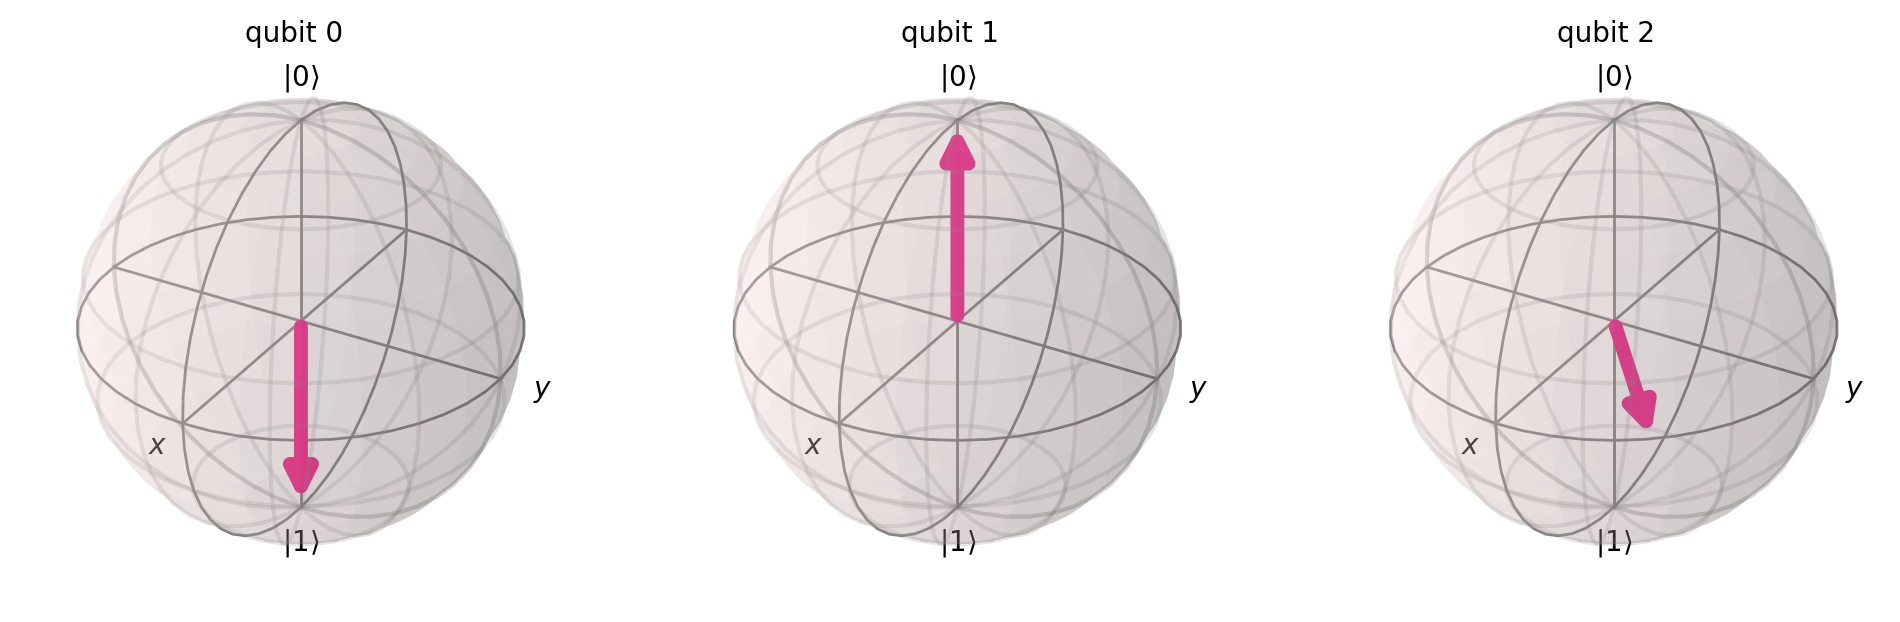

In [16]:
plot_bloch_multivector(res)

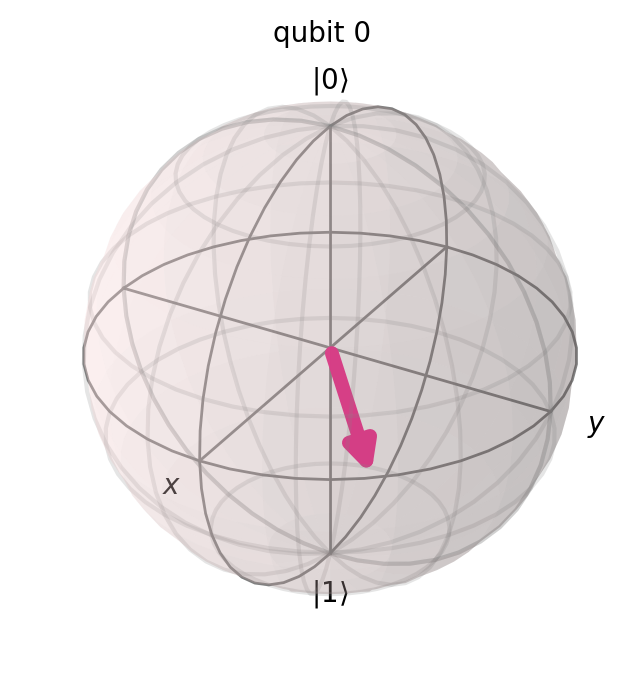

In [17]:
plot_bloch_multivector(sv)

### Exercise 5

In [18]:
def time_evolve(circ, t, dt, w, w0, w1):
    
    def step(circ, T_c):
        circ.rz(-1 * w0 * dt,0)
        circ.rx(2 * dt * w1 * cos(w * T_c),0)
        return circ
    
    times = arange(0, t, dt)
    
    qc = circ
    
    for i in range(len(times)):
        qc = step(qc, times[i])
    
    qc.measure(0,0)
    
    return qc

#### a)

In [19]:
w1 = 2
w0 = 25
w = 25.5
dt = 0.05
backend = Aer.get_backend("qasm_simulator")

def population(t):
    q = QuantumRegister(1)
    c = ClassicalRegister(1)
    circ = QuantumCircuit(q,c)
    
    counts = execute(time_evolve(circ,t, dt, w, w0, w1), backend, shots = 400).result().get_counts()
    return counts.get("1", 0)/400

def analytical(t):
    Omega = sqrt(w1**2 + (w-w0)**2)
    return w1**2/Omega**2 * (sin(Omega * t/2))**2

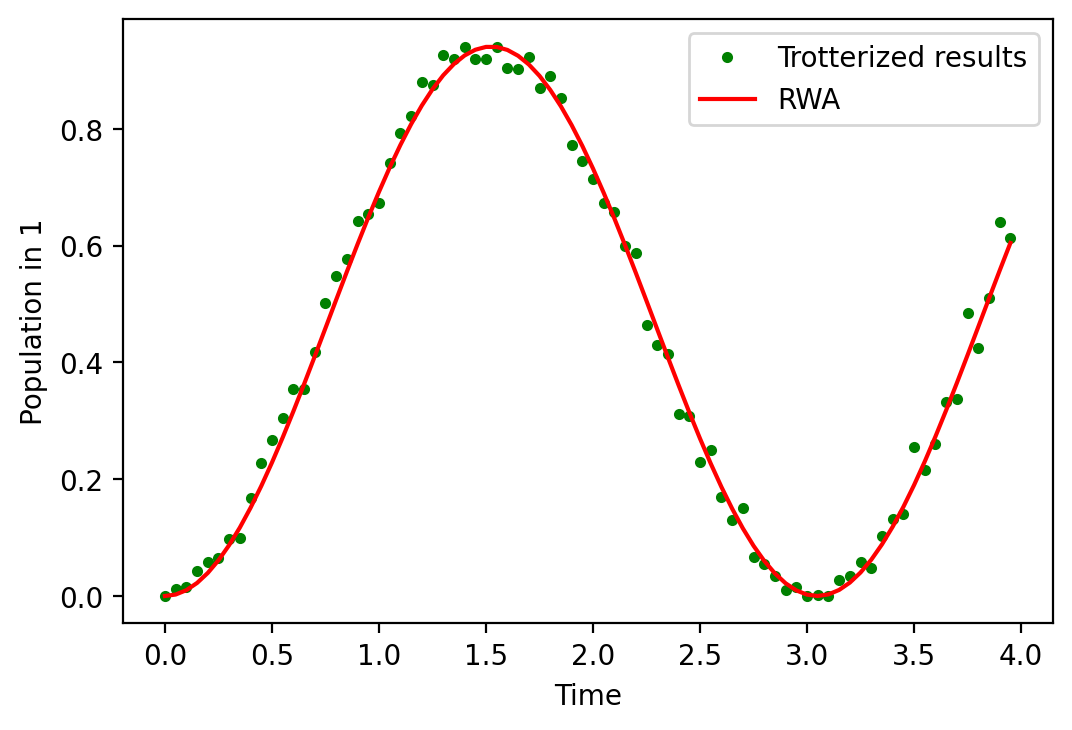

In [20]:
plt.plot(arange(0,4,0.05), [population(0.05 * i) for i in range(80)], "g.", label = "Trotterized results")
plt.plot(arange(0,4,0.05), [analytical(0.05 * i) for i in range(80)], "r-", label = "RWA")
plt.xlabel("Time")
plt.ylabel("Population in 1")
plt.legend()
plt.show()

#### b)

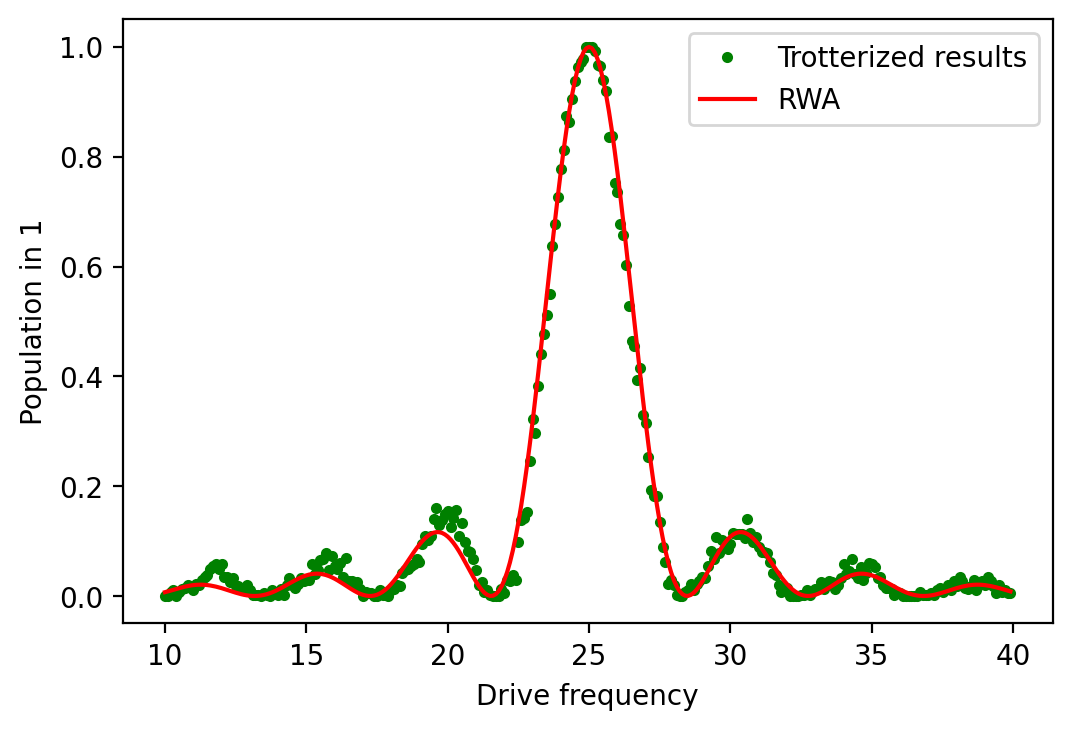

In [21]:
t = pi/w1

def population_b(drive_freq):
    q = QuantumRegister(1)
    c = ClassicalRegister(1)
    circ = QuantumCircuit(q,c)
    
    counts = execute(time_evolve(circ,t, dt, drive_freq, w0, w1), backend, shots = 400).result().get_counts()
    return counts.get("1", 0)/400

def analytical_b(drive_freq):
    Omega = sqrt(w1**2 + (drive_freq - w0)**2)
    return w1**2/Omega**2 * (sin(Omega * t/2))**2

plt.plot(arange(10,40,0.1), [population_b(10 + 0.1 * i) for i in range(300)], "g.", label = "Trotterized results")
plt.plot(arange(10,40,0.1), [analytical_b(10 + 0.1 * i) for i in range(300)], "r-", label = "RWA")
plt.xlabel("Drive frequency")
plt.ylabel("Population in 1")
plt.legend()
plt.show()

#### c)

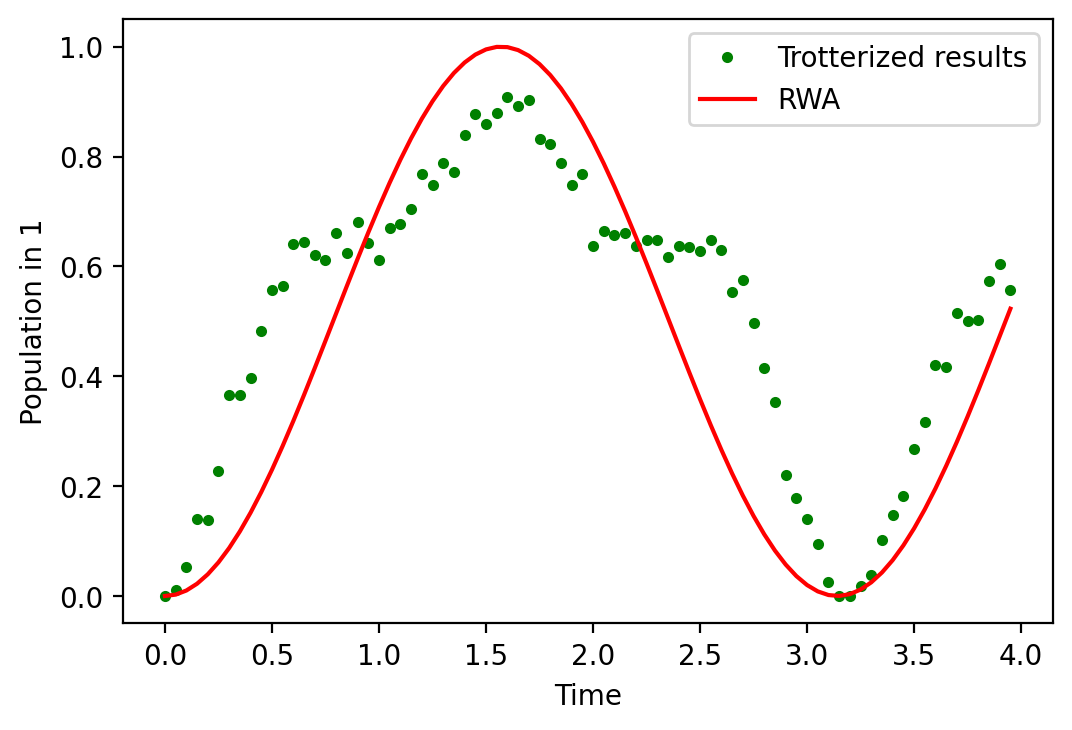

In [22]:
w = w1 = w0 = 2
plt.plot(arange(0,4,0.05), [population(0.05 * i) for i in range(80)], "g.", label = "Trotterized results")
plt.plot(arange(0,4,0.05), [analytical(0.05 * i) for i in range(80)], "r-", label = "RWA")
plt.xlabel("Time")
plt.ylabel("Population in 1")
plt.legend()
plt.show()

RWA assumes drive field frequency is high. Here it's not. 

#### Exercise 6

In [23]:
### redefine global parameters 

gamma = 0.01
p = 0.01
w1 = 2
w0 = 25
w = 25.5

error = amplitude_damping_error(gamma, p)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error, ["rz", "rx"])

simulator = AerSimulator(noise_model = noise_model)

def noisy_population(t, noise_model):
    q = QuantumRegister(1)
    c = ClassicalRegister(1)
    circ = QuantumCircuit(q,c)
    
    counts = simulator.run(time_evolve(circ,t, dt, w, w0, w1), 
                     shots = 400).result().get_counts()
    
    return counts.get("1", 0)/400

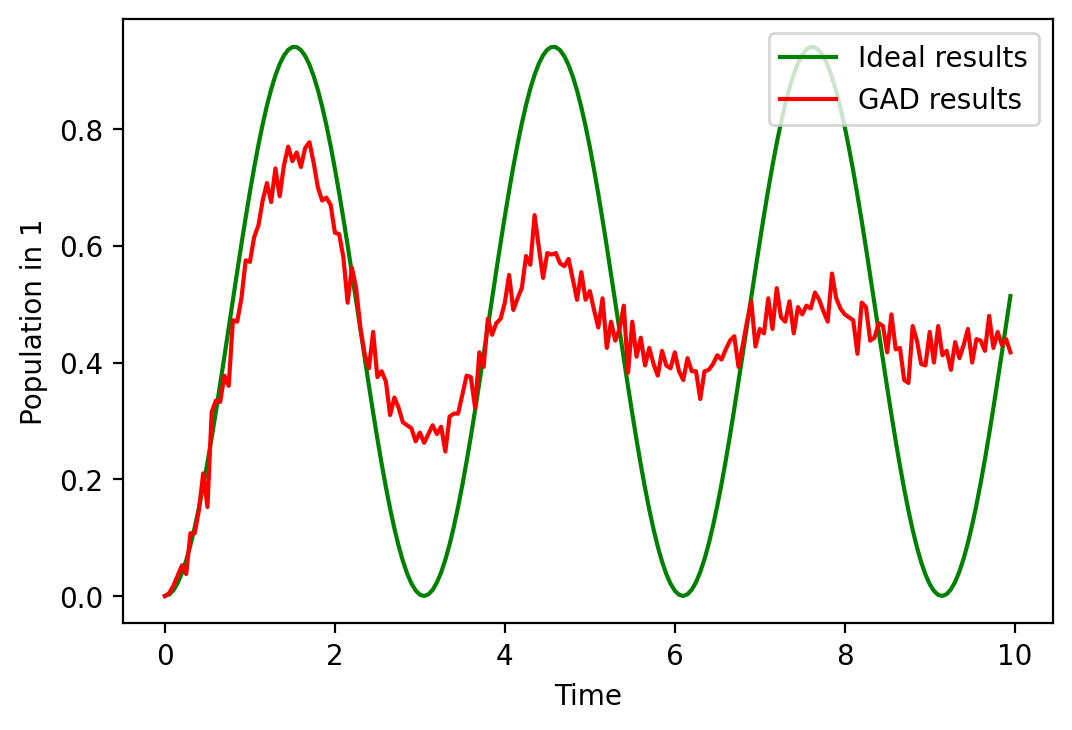

In [24]:
backend = Aer.get_backend("qasm_simulator")
plt.plot(arange(0,10,0.05), [analytical(0.05 * i) for i in range(200)], "g-", label = "Ideal results")
plt.plot(arange(0,10,0.05), [noisy_population(0.05 * i, noise_model) for i in range(200)], "r-", label = "GAD results")
plt.xlabel("Time")
plt.ylabel("Population in 1")
plt.legend()
plt.show()

#### Exercise 8

In [25]:
backend = Aer.get_backend("qasm_simulator")
def expect_z(circ):
    qc = circ
    qc.measure_all()
    counts = execute(qc, backend, shots = 1000).result().get_counts()
    return (counts.get("0", 0) - counts.get("1", 0))/1000

def expect_x(circ):
    qc = circ
    qc.h(0)
    qc.measure_all()
    counts = execute(qc, backend, shots = 1000).result().get_counts()
    return (counts.get("0", 0) - counts.get("1", 0))/1000

def expect_y(circ):
    qc = circ
    qc.rx(pi/2, 0)
    qc.measure_all()
    counts = execute(qc, backend, shots = 1000).result().get_counts()
    return (counts.get("0", 0) - counts.get("1", 0))/1000

### Exercise 9

In [26]:
def T_state():
    qc = QuantumCircuit(1)
    qc.h(0)
    qc.t(0)
    return qc

### because qiskit is a bitch I made a unitary circuit generating the state T instead. 

def reconstruct(state):
    c_x, c_y, c_z = [expect_x(state()), expect_y(state()), expect_z(state())]
    bv = [c_x, c_y, c_z]
    bv /= norm(bv)
    return 1/2 * (np.identity(2) + np.einsum("i,ijk", bv, s))

In [47]:
acc = np.array([reconstruct(T_state) for i in range(100)])
acc = 1/100 * np.sum(acc, axis = 0)

In [48]:
experiment = StateTomography(T_state())
data = experiment.run(backend, seed_simulation = 100).block_for_results()
q_rho = np.matrix(data.analysis_results("state").value)

In [50]:
#### trace distance of our state tomography results for 100 iterations 
### compared to qiskit's for 100. 
D = np.matrix(acc - q_rho)
1/2 * np.trace(D.H @ D).real

9.543273420135491e-05

In [46]:
np.matrix(data.analysis_results("state").value)

matrix([[0.52018507+0.j        , 0.34891332-0.35756406j],
        [0.34891332+0.35756406j, 0.47981493+0.j        ]])

### Problem 10

In [57]:
w1 = 2
w0 = 25
w = 25.5
dt = 0.05

def tomo(t):
    ### gives density matrix [1,1] entry for time t of the trotterized time evolution
    q = QuantumRegister(1)
    c = ClassicalRegister(1)
    circ = QuantumCircuit(q,c)
    
    rab = time_evolve(circ, t, dt, w, w0, w1)
    
    experiment = StateTomography(rab)
    data = experiment.run(backend, seed_simulation = 100).block_for_results()
    q_rho = np.matrix(data.analysis_results("state").value)
    return [q_rho[0,0].real, q_rho[1,1].real]



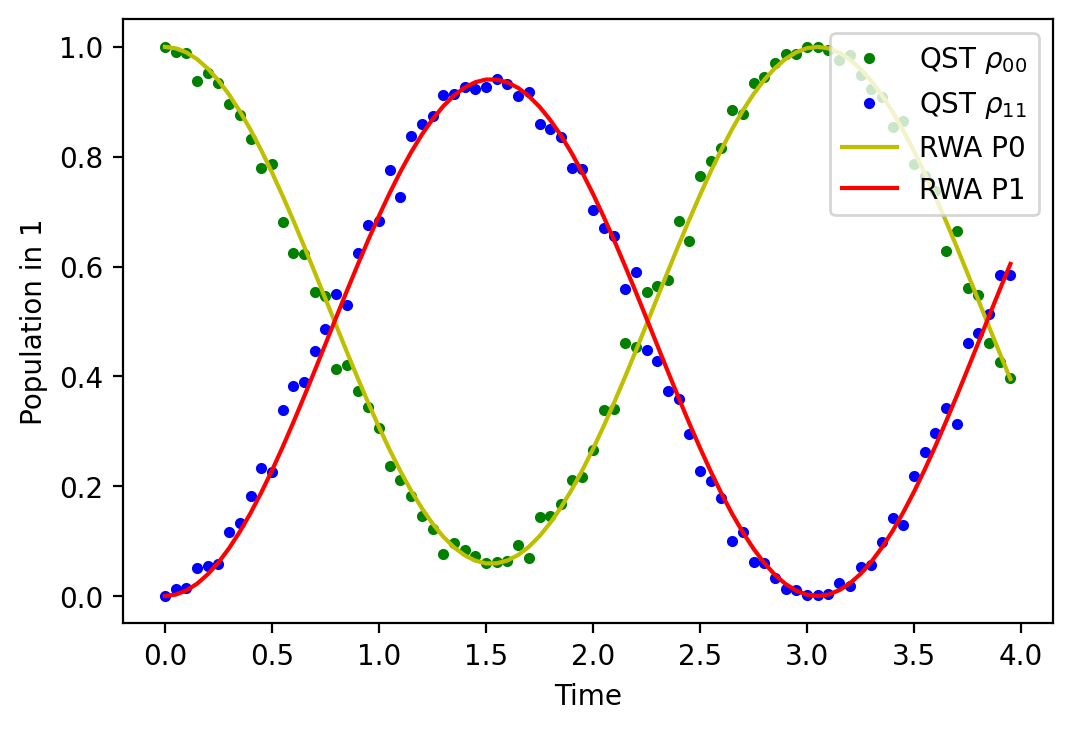

In [59]:
plt.plot(arange(0,4,0.05), np.array([tomo(0.05 * i) for i in range(80)])[:,0], "g.", label = "QST " + r"$\rho_{00}$")
plt.plot(arange(0,4,0.05), np.array([tomo(0.05 * i) for i in range(80)])[:,1], "b.", label = "QST " + r"$\rho_{11}$")
plt.plot(arange(0,4,0.05), [1-analytical(0.05 * i) for i in range(80)], "y-", label = "RWA P0")
plt.plot(arange(0,4,0.05), [analytical(0.05 * i) for i in range(80)], "r-", label = "RWA P1")
plt.xlabel("Time")
plt.ylabel("Population in 1")
plt.legend()
plt.show()

### Problem 11

In [86]:
def PQC(a,b):
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.rzz(-2 * b, 0, 1)
    qc.h(0)
    qc.barrier()
    qc.h(1)
    qc.rzz(-2 * b, 0, 1)
    qc.h(1)
    qc.barrier()
    qc.rz(-2 * a, 0)
    qc.rz(-2 * a, 1)
    return qc

### Problem 12

In [111]:
backend = Aer.get_backend("qasm_simulator")

In [112]:
def H12_expect(qc):
    
    def string1(qc):
        psi = qc.copy()
        psi.h(0)
        psi.measure_all()
        counts = execute(psi, backend, shots = 5000).result().get_counts()
        pos = counts.get("00", 0) + counts.get("11", 0)
        neg = counts.get("01", 0) + counts.get("10", 0)
        contribution = 1/5000 * (pos - neg)
        return contribution
    
    def string2(qc):
        psi = qc.copy()
        psi.h(1)
        psi.measure_all()
        counts = execute(psi, backend, shots = 5000).result().get_counts()
        pos = counts.get("00", 0) + counts.get("11", 0)
        neg = counts.get("01", 0) + counts.get("10", 0)
        contribution = 1/5000 * (pos - neg)
        return contribution
    
    return -1 * (string1(qc) + string2(qc))    

In [114]:
a = np.linspace(0,pi,20)
b = np.linspace(0,pi,20)
a,b = np.meshgrid(a,b)

In [115]:
result = np.array([[H12_expect(PQC(a[i][j], b[i][j])) for j in range(20)] for i in range(20)])

In [116]:
np.unravel_index(np.argmin(result), result.shape)

(5, 5)

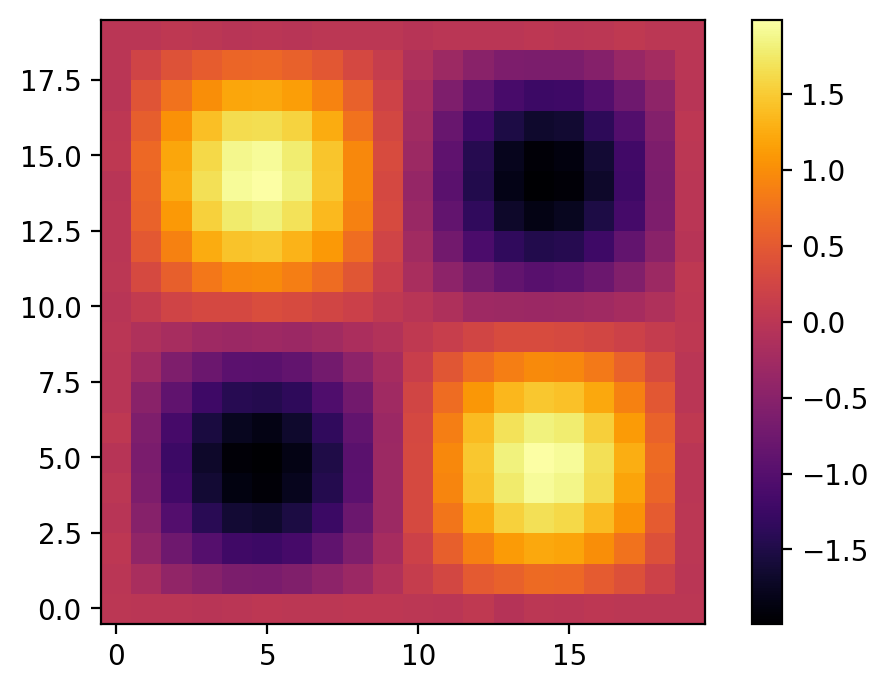

In [121]:
plt.imshow(result, origin = "lower", cmap = "inferno")
plt.colorbar()
plt.show()

### Problem 13

In [130]:
backend = Aer.get_backend("statevector_simulator")
psi_0 = np.matrix(execute(PQC(a[5,5], b[5,5]), backend).result().get_statevector())

psi_true = 1/2 * np.matrix([[1,1,1,-1]])

norm(psi_0.H @ psi_true)

1.0000000000000002

### Problem 14

In [133]:
p = 0.2
gamma = 0.1
error = amplitude_damping_error(gamma, p)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error, ["rz", "h"])

simulator = AerSimulator(noise_model = noise_model)

def noisy_H12_expect(qc):
    
    def string1(qc):
        psi = qc.copy()
        psi.h(0)
        psi.measure_all()
        counts = simulator.run(psi, shots = 5000).result().get_counts()
        pos = counts.get("00", 0) + counts.get("11", 0)
        neg = counts.get("01", 0) + counts.get("10", 0)
        contribution = 1/5000 * (pos - neg)
        return contribution
    
    def string2(qc):
        psi = qc.copy()
        psi.h(1)
        psi.measure_all()
        counts = simulator.run(psi, shots = 5000).result().get_counts()
        pos = counts.get("00", 0) + counts.get("11", 0)
        neg = counts.get("01", 0) + counts.get("10", 0)
        contribution = 1/5000 * (pos - neg)
        return contribution
    
    return -1 * (string1(qc) + string2(qc))    

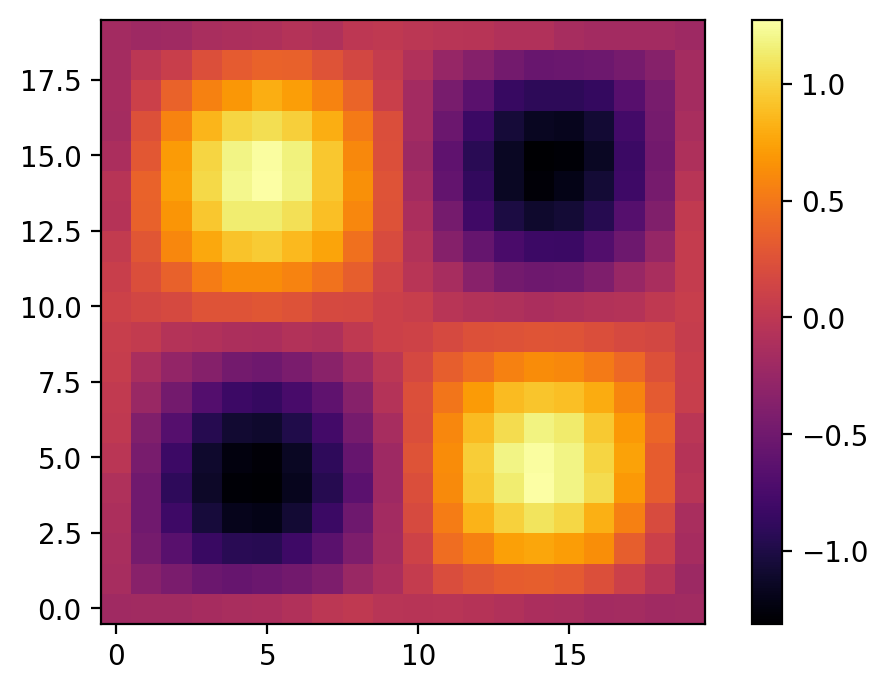

In [135]:
result_noisy = np.array([[noisy_H12_expect(PQC(a[i][j], b[i][j])) for j in range(20)] for i in range(20)])
plt.imshow(result_noisy, origin = "lower", cmap = "inferno")
plt.colorbar()
plt.show()